In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from torch_geometric.utils import from_networkx, to_networkx


import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, Callback, TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger

import numpy as np

from typing import Callable, Optional

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from utils.heterophilic import get_dataset, get_fixed_splits, WebKB, Actor
from project.sheaf_datamodule import SheafDataset_ForGraphs, SheafDataModule_ForGraphs, SheafDataset, SheafDataModule
from project.sheaf_learner import coboundary_learner_on_graph_signal, coboundary_learner
from project.sheaf_diffusion import sheaf_diffusion
from project.toy_sheaf_generator import toy_sheaf_generator

In [5]:
#def __init__(self, Nv, dv, de):
sheaf_10_2_2 = toy_sheaf_generator(5,2,2)

graph = sheaf_10_2_2.generate_er_graph()

true_sheaf = sheaf_10_2_2.random_gaussian_sheaf_on_graph()

samples = sheaf_10_2_2.sample_signal_on_sheaf(57, 100)

samples.shape

(10, 57)

In [6]:
train_data = SheafDataset(False, '/root/projects/', samples, 100)

In [7]:
torch.save(train_data, os.path.join(os.getcwd(), 'testsheaf.pt'))

In [8]:
basedir = os.getcwd()

file_dict = {'train':os.path.join(basedir, 'testsheaf.pt'),
             'val':os.path.join(basedir, 'testsheaf.pt'),
             'test':os.path.join(basedir, 'testsheaf.pt'),
             'predict':os.path.join(basedir, 'testsheaf.pt')}


In [9]:
sheaf_dm = SheafDataModule(file_dict)

In [27]:
graph.number_of_edges()

7

In [28]:
# def __init__(self, graph, Nv, dv, Ne, de, alpha, beta, learning_rate, true_sheaf = None):
model = coboundary_learner(graph, 5, 2, graph.number_of_edges(), 2, 0., 0., 0.0001, true_sheaf)

In [29]:
model

coboundary_learner(
  (coboundary_vec_out): ParameterList(
      (0): Parameter containing: [torch.float32 of size 2x2]
      (1): Parameter containing: [torch.float32 of size 2x2]
      (2): Parameter containing: [torch.float32 of size 2x2]
      (3): Parameter containing: [torch.float32 of size 2x2]
      (4): Parameter containing: [torch.float32 of size 2x2]
      (5): Parameter containing: [torch.float32 of size 2x2]
      (6): Parameter containing: [torch.float32 of size 2x2]
  )
  (coboundary_vec_in): ParameterList(
      (0): Parameter containing: [torch.float32 of size 2x2]
      (1): Parameter containing: [torch.float32 of size 2x2]
      (2): Parameter containing: [torch.float32 of size 2x2]
      (3): Parameter containing: [torch.float32 of size 2x2]
      (4): Parameter containing: [torch.float32 of size 2x2]
      (5): Parameter containing: [torch.float32 of size 2x2]
      (6): Parameter containing: [torch.float32 of size 2x2]
  )
)

In [30]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.000001, patience=5, verbose=False)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/root/projects/temp_checkpoints",
    filename="test-1-sheaflearn-{epoch:02d}-{val_loss:.2f}",
    save_top_k=4,
    mode="min",
)
class PrintCallbacks(Callback):
    def on_init_start(self, trainer):
        print("Starting to init trainer!")

    def on_init_end(self, trainer):
        print("Trainer is init now")

    def on_train_end(self, trainer, pl_module):
        print("Training ended")


In [31]:
import wandb

In [32]:
wandb.finish()
wandb_logger = WandbLogger(project="sheaf_learning_coboundary_learner_toy")

epoch,▁▁▁▂▂▂▃▃▃▅▅▅▆▆▆▇▇▇███
train_conn,▁▆████████████
train_dirichlet,█▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
train_sparse,█▁▃▃▃▃▃▃▃▃▃▃▃▃
trainer/global_step,▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
val_conn,▁██████
val_dirichlet,█▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁
val_sparse,▁██████
epoch,6


In [33]:
trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger,auto_lr_find=True)

Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


In [34]:
lr_finder = trainer.tuner.lr_find(model, sheaf_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /root/projects/sheaf-learn-project/notebooks/.lr_find_d6963256-6f14-4609-8107-217cacd551af.ckpt


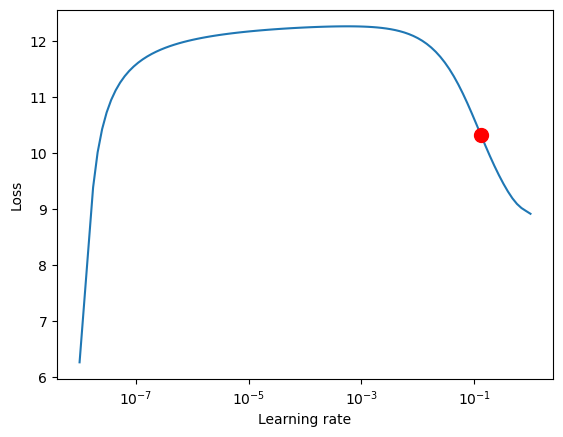

In [35]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [36]:
new_lr = lr_finder.suggestion()
model.hparams.learning_rate = new_lr
model.learning_rate = new_lr

In [37]:
new_lr

0.13182567385564073

In [38]:
trainer.fit(model, sheaf_dm)

/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /root/projects/temp_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type          | Params
----------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


In [39]:
learned_laplacian = model.build_laplacian_from_vector().detach()

In [40]:
learned_laplacian

tensor([[ 8.1968,  2.0786,  0.0648, -0.9566,  0.2359, -0.6145,  1.2508, -1.1918,
         -0.9787,  0.7306],
        [ 2.0786, 10.6051, -0.0336, -0.7746,  0.1220, -0.8370, -2.4806,  0.1553,
         -0.9592,  0.8845],
        [ 0.0648, -0.0336,  0.2222,  0.3160,  0.0000,  0.0000, -0.3463, -0.3706,
          0.0000,  0.0000],
        [-0.9566, -0.7746,  0.3160,  1.9771,  0.0000,  0.0000, -0.1932, -0.9461,
          0.0000,  0.0000],
        [ 0.2359,  0.1220,  0.0000,  0.0000,  0.4148, -1.1827,  0.0000,  0.0000,
         -0.2544,  0.0387],
        [-0.6145, -0.8370,  0.0000,  0.0000, -1.1827,  4.6616,  0.0000,  0.0000,
          1.0876,  0.0929],
        [ 1.2508, -2.4806, -0.3463, -0.1932,  0.0000,  0.0000,  4.0346, -0.8955,
          0.2136,  0.0683],
        [-1.1918,  0.1553, -0.3706, -0.9461,  0.0000,  0.0000, -0.8955,  2.8258,
         -0.3511,  0.1915],
        [-0.9787, -0.9592,  0.0000,  0.0000, -0.2544,  1.0876,  0.2136, -0.3511,
          0.9805, -0.3187],
        [ 0.7306,  

In [41]:
true_sheaf

array([[ 9.04885307,  1.31413905,  0.97017794,  0.28686298, -1.17667975,
         2.70521039, -3.62818368,  1.09488495, -0.94520877,  0.97731228],
       [ 1.31413905,  9.24735734, -0.95736915, -0.4057546 , -1.17376256,
         3.21709311,  1.77738292, -1.841512  , -1.23636448,  1.10345922],
       [ 0.97017794, -0.95736915,  1.72057081,  0.49475231,  0.        ,
         0.        ,  0.15271735, -0.25380601,  0.        ,  0.        ],
       [ 0.28686298, -0.4057546 ,  0.49475231,  1.7199358 ,  0.        ,
         0.        ,  0.37552205,  0.23580531,  0.        ,  0.        ],
       [-1.17667975, -1.17376256,  0.        ,  0.        ,  7.00313665,
        -2.26234427,  0.        ,  0.        ,  4.34204508,  1.50422948],
       [ 2.70521039,  3.21709311,  0.        ,  0.        , -2.26234427,
        13.50921388,  0.        ,  0.        ,  0.88158332,  1.71533554],
       [-3.62818368,  1.77738292,  0.15271735,  0.37552205,  0.        ,
         0.        ,  3.88782226, -1.49711064

In [42]:
np.linalg.norm(model.build_laplacian_from_vector().detach().numpy()-true_sheaf)

19.533631829437606

In [26]:
np.linalg.eig(true_sheaf)[0]

array([17.6045447 , 11.17719474, 10.64782333,  7.57689503,  0.35341369,
        0.69816284,  1.07075276,  3.10458087,  1.96367298,  2.58566757])

In [53]:
np.linalg.eig(learned_laplacian)[0]

array([ 1.5273423e+01,  1.2982228e+01,  7.2698336e+00,  5.4171515e+00,
        1.6669323e+00,  1.3864189e+00,  6.6798395e-01,  2.5678313e-01,
       -1.2255552e-07,  8.8699929e-02], dtype=float32)